In [1]:
# If you run this it won't necessarily give you the best RNN model.
# I've saved the best model that I estimated and I use it in the next Jupyter Notebook.
# This just an example of the steps I took for estimating the model.
stock = 'Google' 
timesteps = 6 # This is the number of lags

## Loading Data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

In [3]:
df = pd.read_csv(f'{stock}.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3871,2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300
3872,2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1393.339966,1502700
3873,2020-01-08,1392.079956,1411.579956,1390.839966,1404.319946,1404.319946,1528000
3874,2020-01-09,1420.569946,1427.329956,1410.270020,1419.829956,1419.829956,1500900
3875,2020-01-10,1427.560059,1434.928955,1418.349976,1429.729980,1429.729980,1820700


In [4]:
data = pd.DataFrame()
data[f'{stock}'] = df['Adj Close'].copy()

In [5]:
data[f'D{stock}'] = data[f'{stock}'].diff()
data['Variance'] = (data[f'D{stock}']-data[f'D{stock}'].mean())**2

In [6]:
data.dropna(axis=0, inplace=True)
data.tail()

,Google,DGoogle,Variance
3871,1394.209961,33.549927,1101.832552
3872,1393.339966,-0.869995,1.503220
3873,1404.319946,10.979980,112.867595
3874,1419.829956,15.510010,229.642085
3875,1429.729980,9.900024,91.087176


## Splitting the data in training and test sample

In [7]:
data_training = pd.DataFrame()
data_test = pd.DataFrame()
data_training['Variance'] = data['Variance'][:-timesteps-3].copy()
data_test['Variance'] = data['Variance'][-timesteps-3:].copy()

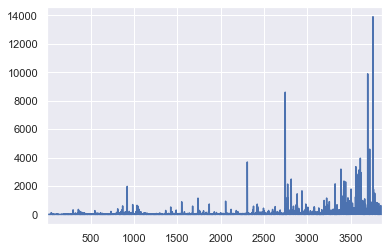

In [8]:
data_training['Variance'].plot()

## Training Data preprocessing

In [9]:
import numpy as np

x_train = []
y_train = []

for i in range(timesteps, data_training.shape[0]):
    x_train.append(data_training['Variance'].iloc[i-timesteps:i].values.tolist())
    y_train.append((data_training['Variance'].iloc[i]))

x_train, y_train = np.array(x_train), np.array(y_train)

x_train.shape, y_train.shape

((3860, 6), (3860,))

## Scaling the data

In [10]:
# I am using logarithmic scale.
from sklearn.preprocessing import FunctionTransformer
scaler = FunctionTransformer(np.log1p, validate=True)
x_train = scaler.fit_transform(x_train)
x_train = x_train[..., np.newaxis]
x_train.shape

(3860, 6, 1)

## Test data preprocessing

In [11]:
x_test = []
y_test = []

for i in range(timesteps, data_test.shape[0]):
    x_test.append(data_test['Variance'].iloc[i-timesteps:i].values.tolist())
    y_test.append((data_test['Variance'].iloc[i]))

x_test, y_test = np.array(x_test), np.array(y_test)

x_test.shape, y_test.shape

((3, 6), (3,))

In [12]:
x_test = scaler.transform(x_test)
x_test = x_test[..., np.newaxis]
x_test.shape

(3, 6, 1)

## Tensorflow Model

In [13]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
model = Sequential()

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (timesteps, 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(units = 60, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(units = 1, activation = 'relu'))

In [15]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

In [16]:
model.compile(optimizer=opt, loss = 'mean_absolute_error')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 60)             14880     
_________________________________________________________________
dropout (Dropout)            (None, 6, 60)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 60)             240       
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 60)             29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 60)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 60)             240       
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                2

In [18]:
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.0)

Train on 3860 samples
Epoch 1/50
3860/3860 [==============================] - 13s 3ms/sample - loss: 79.5320
Epoch 2/50
3860/3860 [==============================] - 6s 1ms/sample - loss: 78.2132
Epoch 3/50
3860/3860 [==============================] - 6s 2ms/sample - loss: 77.4070
Epoch 4/50
3860/3860 [==============================] - 5s 1ms/sample - loss: 77.0473
Epoch 5/50
3860/3860 [==============================] - 5s 1ms/sample - loss: 76.5964
Epoch 6/50
3860/3860 [==============================] - 5s 1ms/sample - loss: 76.6291
Epoch 7/50
3860/3860 [==============================] - 5s 1ms/sample - loss: 76.5122
Epoch 8/50
3860/3860 [==============================] - 4s 1ms/sample - loss: 76.4591
Epoch 9/50
3860/3860 [==============================] - 6s 1ms/sample - loss: 76.3833
Epoch 10/50
3860/3860 [==============================] - 6s 2ms/sample - loss: 76.3837
Epoch 11/50
3860/3860 [==============================] - 5s 1ms/sample - loss: 76.4064
Epoch 12/50
3860/3860 [======

## Evaluating RNN-LSTM Model

In [19]:
y_pred = model.predict(x_test)

In [20]:
from sklearn.metrics import mean_absolute_error
mae = round(mean_absolute_error(y_test, y_pred), 3)
print(mae)

93.201


## Visualization 

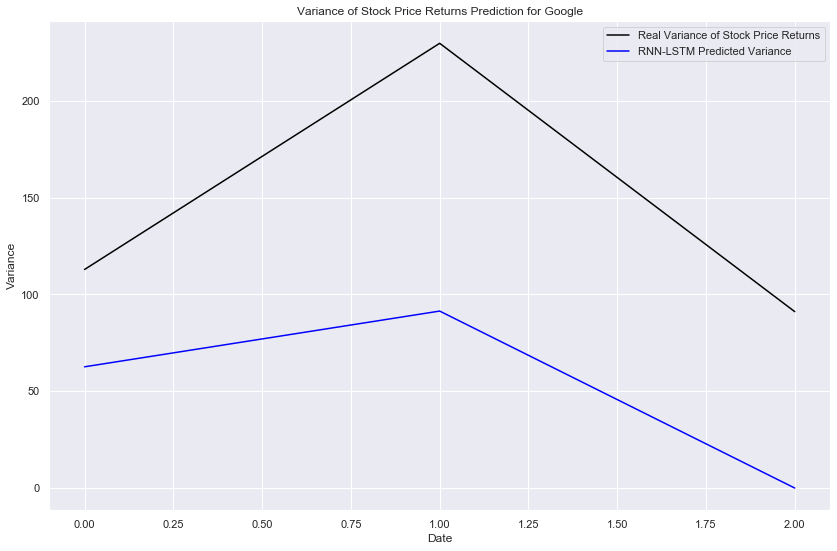

In [21]:
plt.figure(figsize=(14,9))
plt.plot(y_test, color = 'black', label = 'Real Variance of Stock Price Returns')
plt.plot(y_pred, color = 'blue', label = 'RNN-LSTM Predicted Variance')
plt.title(f'Variance of Stock Price Returns Prediction for {stock}')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.legend()
plt.show()